In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)


from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tflscripts
import json
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import svm

configuration = tflscripts.read_configuration()
tflscripts.set_dataset_folder('/home/giotto/transfer-learning-playground/datasets/')

In [2]:
def test_label_with_training_percentage(label, training_percentage):
    dfs = tflscripts.take_multiple_percentages_of_data(df_source, df_source_labels, [training_percentage])
    X_train, df_train_labels = dfs[0]
    X_test, df_test_labels = df_target, df_target_labels

    activity_training_samples = len(df_train_labels[df_train_labels.label == label])
    non_activity_training_samples = len(df_train_labels[df_train_labels.label != label])
    print("Number of activity training samples", activity_training_samples)
    print("Number of non-activity training samples", non_activity_training_samples)

    y_train = tflscripts.get_y_for_label(df_train_labels, label)
    y_test = tflscripts.get_y_for_label(df_test_labels, label)

    clf = svm.SVC(kernel='linear', decision_function_shape='ovr')

    ppl = Pipeline([
        ('impute', Imputer()),
        ('clf', clf)
    ])

    ppl.fit(X_train, y_train)
    
    positive_X_test = X_test[y_test == label]
    positive_y_test = y_test[y_test == label]

    predicted = ppl.predict(positive_X_test)
    accuracy_positive = accuracy_score(predicted, positive_y_test)
    
    print("Accuracy positive", accuracy_positive)
    
    negative_X_test = X_test[y_test != label]
    negative_y_test = y_test[y_test != label]

    predicted = ppl.predict(negative_X_test)
    accuracy_negative = accuracy_score(predicted, negative_y_test)
    
    print("Accuracy negative", accuracy_negative)
    
    return activity_training_samples, non_activity_training_samples, accuracy_positive, accuracy_negative

In [7]:
results = []

activities = [
    "Dishes",
    "Microwave",
    "Coffee",
    "Null",
    "Kettle",
    "Chopping food",
    "Knocking",
    "Vacuum cleaning",
    "Blender running",
    "Alarm"

]
activities_i = [configuration['activities'].index(a) for a in activities]

source_dataset = 'synergy-final-iter4'
source_device = '128.237.250.218'

target_dataset = 'synergy-final-iter5'
target_device = '128.237.227.76'

df_source, df_source_labels = tflscripts.read_and_filter_dataset(
        source_dataset + '-1s',
        source_device,
        use_features='.*',
        use_activities=activities_i,
        scale=True,
        with_feature_selection=False)

df_source = df_source.loc[df_source.index.isin(df_source_labels.index)]
df_source_labels = df_source_labels.loc[df_source_labels.index.isin(df_source.index)]

df_target, df_target_labels = tflscripts.read_and_filter_dataset(
        target_dataset + '-1s',
        target_device,
        use_features='.*',
        use_activities=activities_i,
        scale=True,
        with_feature_selection=False)

df_target = df_target.loc[df_target.index.isin(df_target_labels.index)]
df_target_labels = df_target_labels.loc[df_target_labels.index.isin(df_target.index)]


for activity in activities:

    label = configuration['activities'].index(activity)

    for training_percentage in range(1, 11):
        training_percentage = training_percentage / 10

        print(activity, training_percentage)

        activity_training_samples, non_activity_training_samples, accuracy_positive, accuracy_negative = \
            test_label_with_training_percentage(label, training_percentage)

        results.append({
            'activity': activity,
            'training_percentage': training_percentage,
            'accuracy_positive': accuracy_positive,
            'accuracy_negative': accuracy_negative,
            'activity_training_samples': activity_training_samples,
            'non_activity_training_samples': non_activity_training_samples
        })

Dishes 0.1
Number of activity training samples 62
Number of non-activity training samples 410
Accuracy positive 0.75
Accuracy negative 0.998325519089
Dishes 0.2
Number of activity training samples 125
Number of non-activity training samples 818
Accuracy positive 0.752659574468
Accuracy negative 0.997320830543
Dishes 0.3
Number of activity training samples 162
Number of non-activity training samples 1252
Accuracy positive 0.829787234043
Accuracy negative 0.99698593436
Dishes 0.4
Number of activity training samples 230
Number of non-activity training samples 1656
Accuracy positive 0.832446808511
Accuracy negative 0.992967180174
Dishes 0.5
Number of activity training samples 296
Number of non-activity training samples 2062
Accuracy positive 0.86170212766
Accuracy negative 0.99698593436
Dishes 0.6
Number of activity training samples 357
Number of non-activity training samples 2472
Accuracy positive 0.867021276596
Accuracy negative 0.997990622907
Dishes 0.7
Number of activity training sampl

Accuracy positive 0.972826086957
Accuracy negative 0.994321977288
Chopping food 0.3
Number of activity training samples 169
Number of non-activity training samples 1245
Accuracy positive 0.978260869565
Accuracy negative 0.997327989312
Chopping food 0.4
Number of activity training samples 236
Number of non-activity training samples 1650
Accuracy positive 0.986413043478
Accuracy negative 0.995991983968
Chopping food 0.5
Number of activity training samples 294
Number of non-activity training samples 2064
Accuracy positive 0.989130434783
Accuracy negative 0.995657982632
Chopping food 0.6
Number of activity training samples 354
Number of non-activity training samples 2475
Accuracy positive 0.989130434783
Accuracy negative 0.997661990648
Chopping food 0.7
Number of activity training samples 412
Number of non-activity training samples 2888
Accuracy positive 0.989130434783
Accuracy negative 0.997661990648
Chopping food 0.8
Number of activity training samples 470
Number of non-activity training

Increasing number of training samples with transfer


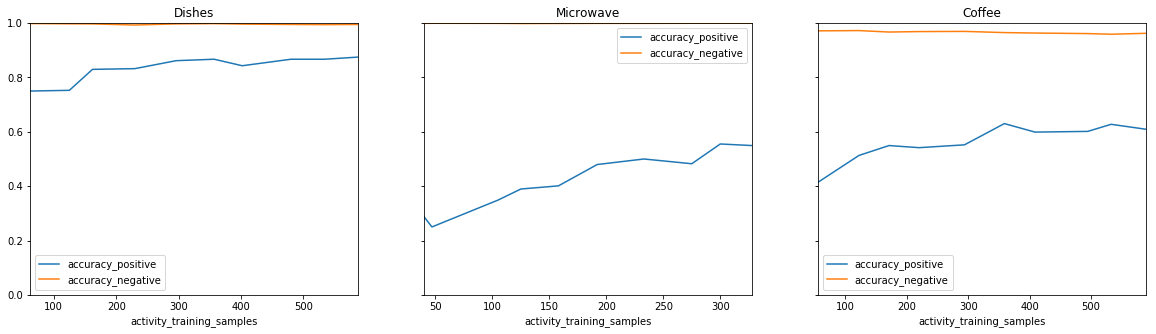

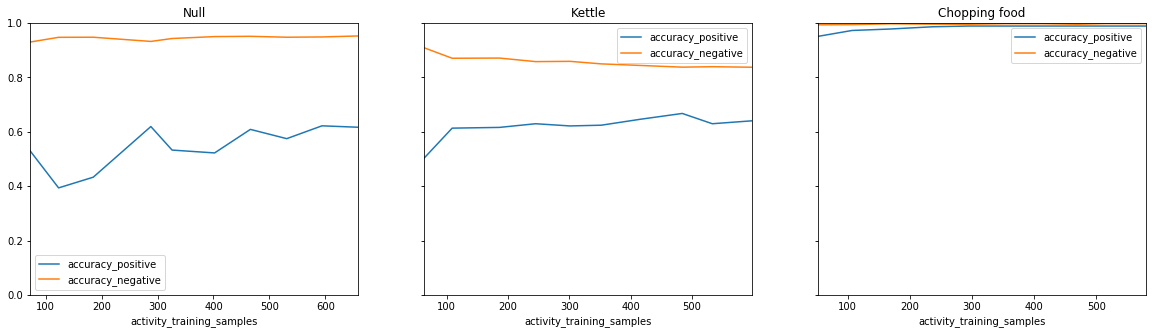

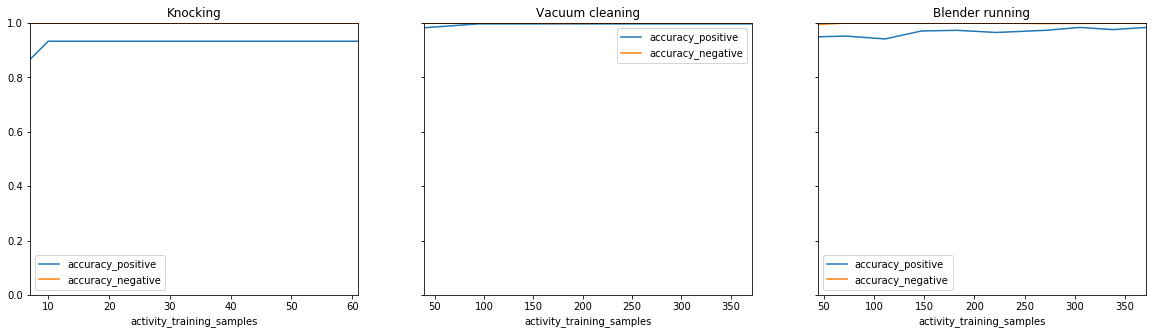

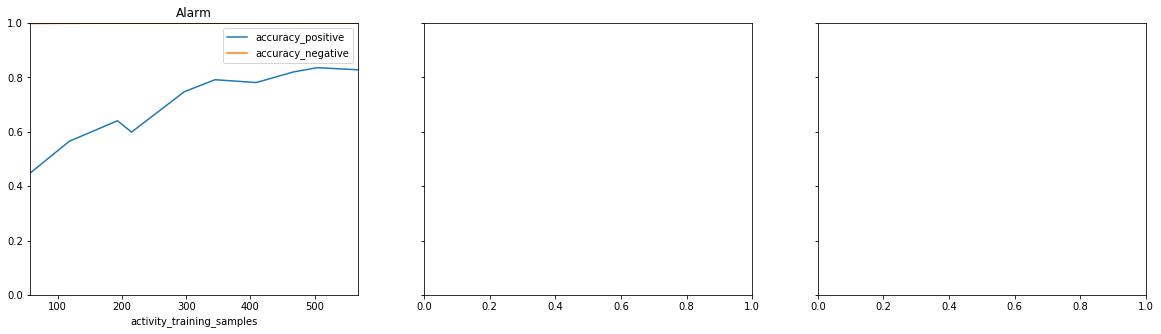

In [8]:
print('Increasing number of training samples with transfer')
plt.rcParams["figure.figsize"] = (20, 5)

df = pd.DataFrame(results)

axes = []
for activity in df.activity.unique():
    if len(axes) == 0:
        f, axes = plt.subplots(1, 3, sharex=False, sharey=True)
        axes = axes.tolist()

        plt.ylim([0,1])
    ax = axes.pop(0)

    activity_df = df.loc[df.activity == activity]
    activity_df = activity_df[['activity_training_samples', 'accuracy_positive', 'accuracy_negative']]
    activity_df = activity_df.set_index('activity_training_samples')
    activity_df.plot(ax=ax)
    matplotlib.pyplot.sca(ax)
    plt.title(activity)